# OpenStreetMap Data Wrangling Project

# Data quality process

* ** Program: ** Data Analyst Nanodegree 
* ** Student: ** Guillermo Naranjo
* ** Date:** August 14, 2017

## Objective
* Describe extraction from OSM file and basic cleaning process to generate entities CSV files.
* Provide the steps applied to load CSV files into the **SQLite** project database.
* Apply and describe data exploration and quality process applied to osm database.

## Map Area and data extration

The area selected (were I live) was [Costa Rican greater metropolitan area](https://www.openstreetmap.org/export#map=11/9.9428/-83.9960). The xml extract was obtained using [Overpass Query form](http://overpass-api.de/query_form.html) query: *(node(9.8156,-84.2868,10.0453,-83.8449); <; ); out meta;*. 

The resulting osm file was named [costa_rica_greater_metropolitan_area.osm](costa_rica_greater_metropolitan_area.osm) (71.2 MB).

## Initial exploration
Using Notepad++ I managed to take a look at the XML file. Found some data quality issues that can be corrected just by looking at the raw data. ** I think these findings are a good starting point for a first few data cleaning iterations **

* Multiple node names have , and ; as part of their name:
```
<node id="114940955" lat="9.9851645" lon="-84.1639499" version="6" timestamp="2015-11-04T05:16:35Z" changeset="35071183" uid="126508" user="Canyonsrcool">
    <tag k="exit_to" v="111, Plaza Real Cariari"/>
    <tag k="highway" v="motorway_junction"/>
    <tag k="name" v="111"/>
</node>
```
* There are different ways to describe node attributes like postal code:
```
<node id="267631593" lat="9.9954876" lon="-84.0967814" version="12" timestamp="2015-12-09T17:24:04Z" changeset="35850500" uid="1104904" user="joserrg12">
    <tag k="is_in" v="San Pablo, Heredia"/>
    <tag k="name" v="San Pablo"/>
    <tag k="place" v="town"/>
    <tag k="population" v="20000"/>
    <tag k="postal_code" v="40901"/>
</node>
<node id="267631658" lat="10.0137021" lon="-84.0997492" version="13" timestamp="2015-12-10T00:54:35Z" changeset="35857380" uid="1104904" user="joserrg12">
    <tag k="addr:postcode" v="40501"/>
    <tag k="is_in" v="San Rafael, Heredia"/>
    <tag k="name" v="San Rafael"/>
    <tag k="place" v="town"/>
    <tag k="population" v="42000"/>
</node>
```
* There is html code in attribute values:
```
<node id="4306250893" lat="9.9394867" lon="-84.0866537" version="1" timestamp="2016-07-16T19:22:57Z" changeset="40785993" uid="4197485" user="Анна Я">
    <tag k="name" v="Hotel Sura B&amp;B"/>
    <tag k="tourism" v="hostel"/>
</node>
```
* There are multiple phone formats:
```
<tag k="phone" v="2560 6738"/>
<tag k="phone" v="+50625111334"/>
<tag k="phone" v="40306951"/>
<tag k="phone" v="506 2233 6365"/>
<tag k="phone" v="+506 2232-2918/ 2290-3330"/>
```

## Database schema
* Only **version** datatype was changed in data extraction from 'string' to 'integer' in order to match database schema.

```
$ sqlite3 osm_costa_rica.db
```

```
CREATE TABLE nodes (
    id INTEGER PRIMARY KEY NOT NULL,
    lat REAL,
    lon REAL,
    user TEXT,
    uid INTEGER,
    version INTEGER,
    changeset INTEGER,
    timestamp TEXT
);

CREATE TABLE nodes_tags (
    id INTEGER,
    key TEXT,
    value TEXT,
    type TEXT,
    FOREIGN KEY (id) REFERENCES nodes(id)
);

CREATE TABLE ways (
    id INTEGER PRIMARY KEY NOT NULL,
    user TEXT,
    uid INTEGER,
    version TEXT,
    changeset INTEGER,
    timestamp TEXT
);

CREATE TABLE ways_tags (
    id INTEGER NOT NULL,
    key TEXT NOT NULL,
    value TEXT NOT NULL,
    type TEXT,
    FOREIGN KEY (id) REFERENCES ways(id)
);

CREATE TABLE ways_nodes (
    id INTEGER NOT NULL,
    node_id INTEGER NOT NULL,
    position INTEGER NOT NULL,
    FOREIGN KEY (id) REFERENCES ways(id),
    FOREIGN KEY (node_id) REFERENCES nodes(id)
);
```

# Extraction, Transformation into CSV files and data Load to SQLite database

### Extraction and transformation

The following script **[extract_osm_data.py](extract_osm_data.py)** was applied in order to parse osm xml, generating the following csv files used later to populate the osm database:
* nodes.csv: 24.6 MB
* nodes_tags.csv: 0.7 MB
* ways.csv: 3.3 MB
* ways_tags.csv: 3.7 MB
* ways_nodes.cv: 9.4 MB 

### Data imports
As suggested in the module CSV files were imported to each table, previously setting up the mode and header parameters as required.

```
.mode csv
.separator ","
.headers on
.import nodes.csv nodes
.import nodes_tags.csv nodes_tags
.import ways.csv ways
.import ways_nodes.csv ways_nodes
.import ways_tags.csv ways_tags
```
This process results in a database with the size:

* osm_costa_rica.db: 37.1 MB

Record count:
```
sqlite> select count(*) from nodes;
299725

sqlite> select count(*) from nodes_tags;
20095

sqlite> select count(*) from ways;
54689

sqlite> select count(*) from ways_tags;
107826

sqlite> select count(*) from ways_nodes;
386122
```

# Audit data
To be aligned to the module data quality process we need to follow this measures in order to have a better understanding of current data quality. For project purposes, I put some ideas on how to deal with them in each case. 

Validity (conforms to schema)
* There were validations already applied using [extract_osm_data.py](extract_osm_data.py) script like: (1) data type validations against the schema provided, (2) checking if there are problematic characters (commas for example) in the data that could cause some problem in CSV format and (3) verifying we are sending the right types to the CSV.
* Phone number formats, we found several phone number formats that can be unified.
* Tag names with wrong data, that contains problematic characters or html code that can be cleaned (not ignored).

Accuracy (conforms to gold standard)
* In some cases, specially in node or way names are will not match "expected names" corrections will be required.

Completeness (are there missing values)
* A basic process was already applied in osm data extraction; besides that, I will be checking if there are missing values or ids with null values. 

Consistency (matches other data)
* I will verify referencial integrity by checking if foreign keys are well established. 

Uniformity (same units)
* There are a few cases where units will be validate to comply uniformity.

** Based on those quality measured we will process to audit quiality aspects of each database entity below. ** 

### Nodes and Ways

I initially looked for **completeness** in nodes but after some exploration the data looks complete:
```
select * from nodes where id <= 0 or user = "";
0 records
select * from nodes where lon = 0 or lat = 0;
0 records
```
Then I looked for some basic analysis to visualize user collaboration by nodes and check **uniformity** (not weird outliers, etc) and looks normal:
```
.header on
.output node_users.csv
select user, count(*) as quantity from nodes group by user order by count(*) desc;
```

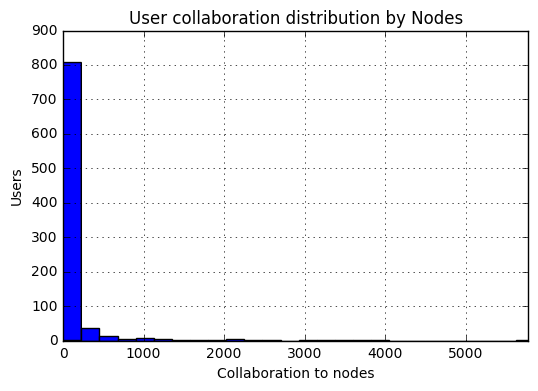

In [1]:
%matplotlib inline
import pandas as pd
import csv
import matplotlib.pyplot as plt

node_users = pd.read_csv('node_users.csv', delimiter="|")
fig, ax = plt.subplots()
plt.hist(node_users['quantity'],bins=250)
plt.xlabel('Collaboration to nodes')
plt.ylabel('Users')
plt.title('User collaboration distribution by Nodes')
plt.xlim([0,5774])
plt.grid(True)
plt.show()

In [2]:
node_users.head(12)

user  quantity
0          joserrg12     56225
1             TI2KOL     36107
2           droopycr     15151
3    Rodolfo Quesada     14864
4            vogtgbr     13655
5       Canyonsrcool     13617
6         BlueSombra     12766
7          recinutah     12111
8       esbarquero90     10979
9         devdelgado      7678
10           lishkin      6671
11  Jorge_Chinchilla      5774

* From the 299725 user contributors, there are at least 800 users that collaborates with less than 100 articles but the most active user accounts for 56225 nodes. A dozen people are the greatest contributors.

### Nodes and Ways Tags

Nodes tags **types are consistent**, there are no duplicate types that require unification, verified using the following query:
```
select distinct type from nodes_tags order by type asc;

type
addr
building
capacity
contact
currency
diet
disused
fire_hydrant
fuel
generator
health_facility
healthcare
internet_access
is_in
level
name
naptan
payment
public_transport
ref
regular
service
social_facility
source
toilets
tower
type
volcano
```
But node tags **names** maybe not so much, we could have duplicated keys:
```
select distinct key from nodes_tags order by key asc;
key
alt_name
alt_name_1
highway
highway_1
name
name_1
phone
phone_1
postal_code
postcode
source
source_1
speciality
speciality_1
```
Now, if we look at some of the nodes_tags it seems there's no need worry since those keys are used when you have more than one type of attribute, like **contact type / phone key** in this case:
```
select * from nodes_tags where id = 3445201840;
id|key|value|type
3445201840|amenity|restaurant|regular
3445201840|phone|2253-8426|contact
3445201840|phone_1|2253-8367|contact
3445201840|smoking|no|regular
```
Looking closer to postal codes, I found that postal code key is used both as postcode or postal_code and **needs uniformity**. Values looks good though:
```
select * from nodes_tags where key like '%post%';
267631593|postal_code|40901|regular
267631658|postcode|40501|addr
267632809|postal_code|40601|regular
272876548|postcode|10105|addr
272876550|postcode|11801|addr
272876556|postcode|10109|addr
272902096|postcode|10201|addr
273104979|postcode|10107|addr
273106202|postal_code|10111|regular
273114688|postcode|11001|addr
275730904|postal_code|20101|regular
```
To explore nodes_tags **values** I will focus in the top 40 of 211 (20%) keys and for those keys I'll take a look at the values to see if there are quality issues to fix:
```
select distinct a.key, b.value from (select  key,count(*) as total_key from nodes_tags group by key order by count(*) desc limit 40) a join nodes_tags b on a.key = b.key order by a.total_key desc;
    
    
select distinct a.key, b.value from (select  key,count(*) as total_key from ways_tags group by key order by count(*) desc limit 40) a join ways_tags b on a.key = b.key order by a.total_key desc, length(value) desc;

```
Found some values that can be corrected to conform **accuracy** since I know there are wrong like stores names for example:
```
name,AM-PM
name,AMPM
name,Aerocasillas
name,Aeroscasillas
name,Azafran
name,"Azafrán"
name,Cerrajeria
name,"Cerrajería"
name,Coopeservidores
name,Coopeserviodores
name,JetBox
name,Jetbox
name,Macrobiotica
name,"Macrobiótica"
name,MegaSuper
name,Megasuper
name,Metropolis
name,"Metrópoli"
name,"Metrópolis"
name,Musammani
name,Musmani
name,Musmanni
name,Musmanny
name,Mussmani
name,Muswanni
name,Panaderia
name,"Panadería"
name,Perimercado
name,Perimercados
name,Pizzeria
name,"Pizzería"
name,Pulperia
name,"Pulpería"
name,Quiros
name,"Quirós"
name,Veterinaria
name,Veterniaria
city,Cartago
city,Cartago1
city,Rohmoser
city,Rohrmoser
place,Rohrmoser
```
Also, by looking at phone key, I found that there are multiple phone number formats and they need to be corrected to conform **consistency** with (506)########. Phone with less than 8 numeric characters will be excluded:
```
select key, value from nodes_tags where key = 'phone' order by length(value) desc;
phone,tel:2231-0024
phone,(506)2239-5717
phone,506-7010-1771
phone,(506)22535354
phone,506-2430-2929
phone,5062511556402
phone,506-2228-9541
phone,905-246-3722
phone,50688804660
phone,2290-40-85
phone,2254-6281
phone,25240006 <- excluded
phone,2801712 <- excluded
phone,17-22 <- excluded
phone,0 <- excluded
```

Also, **uniformity** in numeric keys like 'population' looks alright:

```
select value as population from nodes_tags where key='population' order by  CAST(value as INTEGER) desc;
```

### Completeness
There are some queries that check if the foreign keys match id in related tables to check completeness/referential integrity among entities:
```
select count(*) from nodes a join nodes_tags b on a.id = b.id;

```
OK: Record count match nodes_tags.

```
select count(*) from nodes a join nodes_tags b on a.id = b.id;

```
OK: Record count match ways_tags.

```
select count(*) from ways_nodes a join ways b on a.id = b.id;

```
OK: Record count match ways_nodes.

```
select count(*) from ways_nodes a join nodes b on a.node_id = b.id;

```
**Possible issue:** We have aroung 7,000 missing nodes to match ways_nodes record count. 

# Cleaning plan

These are the elements I will focus for data cleaning:

1. A **validity** check was already applied in osm [data extraction](extract_osm_data.py) script.
2. Postal_code and postcode need to comply **uniformity** in a single field.
3. Phone numbers require **consistency** between formats.
4. Tag name values need to be corrected to apply conform **accuracy** to match a expected value list.
5. There are missing referenced nodes in ways_nodes entity to conform **completeness**. We need to verify why.

Points 2 to 4 are addressed programattically using [clean_osm_data.py](clean_osm_data.py) script as described below.


* **Name uniformity** script will map expected names, updating those unexpected with right values. 

### Postal code unification
**Causes**: No reasonable cause was found since similar records with the same user reports two different ways to describe a postcode. *postcode* key with type 'addr' will be selected as the correct to specify updating wrong records in our database: 
```
  <node id="267631593" lat="9.9954876" lon="-84.0967814" version="12" timestamp="2015-12-09T17:24:04Z" changeset="35850500" uid="1104904" user="joserrg12">
    <tag k="is_in" v="San Pablo, Heredia"/>
    <tag k="name" v="San Pablo"/>
    <tag k="place" v="town"/>
    <tag k="population" v="20000"/>
    <tag k="postal_code" v="40901"/>
  </node>
  <node id="267631658" lat="10.0137021" lon="-84.0997492" version="13" timestamp="2015-12-10T00:54:35Z" changeset="35857380" uid="1104904" user="joserrg12">
    <tag k="addr:postcode" v="40501"/>
    <tag k="is_in" v="San Rafael, Heredia"/>
    <tag k="name" v="San Rafael"/>
    <tag k="place" v="town"/>
    <tag k="population" v="42000"/>
  </node>
```
**Operations**: 

* **[clean_osm_data.py](clean_osm_data.py)** script contains the function **unify_postcodes** that updates nodes and ways tags table to unify postalcode keys and values. It updates the database as follow:

```
UPDATE nodes_tags SET key = 'postcode', type = 'addr' WHERE key='postal_code';

UPDATE ways_tags SET key = 'postcode', type = 'addr' WHERE key='postal_code';
```

**Test**: Once applied the change, the following script does not return any data, as expected.
```
select * from nodes_tags where key = 'postal_code';

select * from ways_tags where key = 'postal_code';
```
** Result**: successful.

### Phone number standarization
**Causes**: users included different phone number gathered from different places and it has caused this issue. 

**Operations**: **[clean_osm_data.py](clean_osm_data.py)** use **pandas** routines that will look for problematic phone numbers and will fix them. Following these steps:

* Look for phones subframe inside tags frame.
* Validates if each value matches the expected phone number using Apply function **is_valid_phone**.
* If there is a mismatch, the script apply a new format with function **fix_phone**.
* Updates database.

**Test**: Once applied the change, the following script returns only well formated phone numbers, as expected.
```
select value from nodes_tags where key = 'phone';

select value from ways_tags where key = 'phone';
```
** Result**: successful, only 15 numbers were ignored to apply manual correction.

### Tag names correction
**Causes**: acccents, dash and other character are causing inconsistencies among names.

**Operations**: **[clean_osm_data.py](clean_osm_data.py)** script contains the method **update_name** to conform consistency:
* if the tag name in a to_be_corrected name list, then it will return the expected name and then updated.
* changes are later commited to oms_database.
* the following mapping is used to compare and set expected data:

```
mapping ={
	"AM-PM":"AMPM",
	"Aeroscasillas":"Aerocasillas",
	"Azafran":"Azafrán",
	"Cerrajeria":"Cerrajería",
	"Coopeserviodores":"Coopeservidores",
	"JetBox":"Jetbox",
	"Macrobiotica":"Macrobiótica",
	"MegaSuper":"Megasuper",
	"Metropolis":"Metrópolis",
	"Metropoli":"Metrópolis",
	"Musammani":"Musmanni",
	"Musmani":"Musmanni",
	"Musmanny":"Musmanni",
	"Mussmani":"Musmanni",
	"Muswanni":"Musmanni",
	"Panaderia":"Panadería",
	"Pizzeria":"Pizzería",
	"Pulperia":"Pulpería",
	"Quiros":"Quirós",
	"Veterniaria":"Veterinaria",
	"Cartago1":"Cartago",
	"Rohmoser":"Rohrmoser"
}
```

**Test**: the same query will be applied to verify names are now alright:

```
select distinct a.key, b.value from (select  key,count(*) as total_key from nodes_tags group by key order by count(*) desc limit 40) a join nodes_tags b on a.key = b.key order by a.total_key desc;
    
    
select distinct a.key, b.value from (select  key,count(*) as total_key from ways_tags group by key order by count(*) desc limit 40) a join ways_tags b on a.key = b.key order by a.total_key desc, length(value) desc;

```

** Result**: successful, it replaces wrong names with correct ones.

### Missing reference way_nodes assesment
**Causes** After a few minutes I concluded that it was a mistake. I had to apply left outer joins to correctly compare tables:
```
sqlite> select count(*) from ways_nodes a;
386122
sqlite> select count(*) from ways_nodes a left outer join nodes b on a.node_id = b.id;
386122
sqlite> select count(*) from ways_nodes a left outer join ways b on a.id = b.id;
386122
```
**Result**: Nothing to do, all good!

## Applying cleaning plan
This **[clean_osm_data.py](clean_osm_data.py)** script can be executed several times to programmatically clean our data following the cleaning plan described above.

# Conclusion

Once reviewed the information extracted from OSM, it looks like Costa Rica has a small group of contributors and data gathered from "KG Ground Survey 2014". Most information is related to nodes and we have much to improve to ways information.

On the other hand, the data seems ok, been the names, phone numbers and postal codes attributes that require more quality efforts.

I tried to follow as much Audacity resources as possible but got impacted by encoding issues. Some findings are included as comments in the code, I used https://stackoverflow.com a lot to deal with those issue.

I finally tried used pandas and custom functions to deal with data cleaning as well and I liked it. 

Since the data extract didn't contained as much measures as I would expect I couldn't play that much with statistical analysis to check outliers and similar issues.

Best regards,
Guillermo